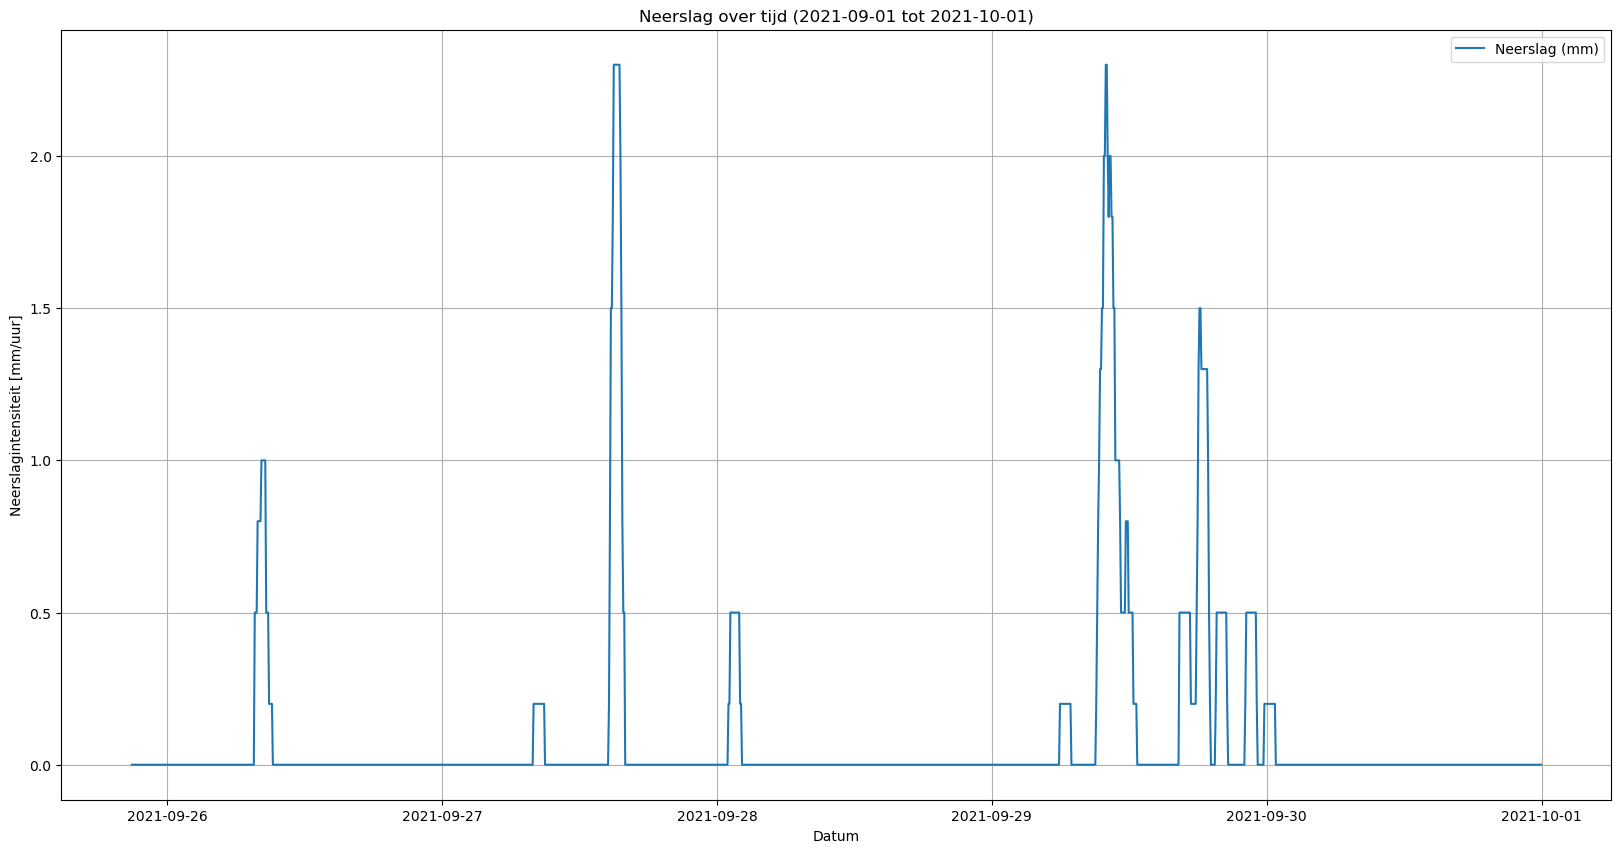

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.1666666666666665e-05, 4.1666666666666665e-05, 4.1666666666666665e-05, 6.666666666666667e-05, 6.666666666666667e-05, 6.666666666666667e-05, 6.666666666666667e-05, 8.333333333333333e-05, 8.333333333333333e-05, 8.333333333333333e-05, 8.333333333333333e-05, 8.333333333333333e-05, 4.1666666666666665e-05, 4.1666666666666665e-05, 4.1666666666666665e-05

In [2]:
# Lijstje van de benodigde imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Omzetten verkregen dataset KNMI naar lijst met gefilterde waardes

# Inladen neerslagdata
df_neerslag = pd.read_csv('Neerslag_Hoogmade.csv', skipinitialspace=True, header=0, sep=';')

# Maak een datum kolom
df_neerslag['DateTime'] = pd.to_datetime(df_neerslag['datum'])  # format is voor notatie van de import

# Zet 'neerslagintensiteit (mm/uur)' om naar numerieke waarden
df_neerslag['neerslagintensiteit (mm/uur)'] = pd.to_numeric(df_neerslag['neerslagintensiteit (mm/uur)'], errors='coerce')

# Vervang NaN door 0
df_neerslag['neerslagintensiteit (mm/uur)'].fillna(0, inplace=True)

# Datumfilter instellen van 2021-09-01 tot 2021-10-01
start_date = '2021-09-01'
end_date = '2021-10-01'

# Selecteer de rijen binnen het gewenste datum bereik
df_filtered = df_neerslag[(df_neerslag['DateTime'] >= start_date) & (df_neerslag['DateTime'] <= end_date)]

# Plot de DateTime tegenover de RH voor het gefilterde bereik
plt.figure(figsize=(20, 10))
plt.plot(df_filtered["DateTime"], df_filtered["neerslagintensiteit (mm/uur)"], label="Neerslag (mm)")
plt.title("Neerslag over tijd ({} tot {})".format(start_date, end_date))
plt.xlabel("Datum")
plt.ylabel("Neerslagintensiteit [mm/uur]")
plt.grid(True)
plt.legend()
plt.show()

# Omzetten neerslag naar mm, daarna naar m, door 12 om van mm/uur naar mm/5 min te gaan
df_neerslag['neerslagintensiteit (mm/uur)'] = df_neerslag['neerslagintensiteit (mm/uur)'] / 1000 / 12

# Haal alle waarden van 'neerslagintensiteit (mm/uur)' op als lijst
neerslag_lijst = df_neerslag['neerslagintensiteit (mm/uur)'].tolist()

print(neerslag_lijst)
